# Transfer Learning

Using the high level transfer learning APIs, you can easily customize pretrained models for feature extraction or fine-tuning. 

In this notebook, we will use a pre-trained Inception_V1 model. But we will operate on the pre-trained model to freeze first few layers, replace the classifier on the top, then fine tune the whole model. And we use the fine-tuned model to solve the dogs-vs-cats classification problem,

## Preparation

### 1. Get the dogs-vs-cats datasets

Download the training dataset from https://www.kaggle.com/c/dogs-vs-cats and extract it. 

The following commands copy about 1100 images of cats and dogs into demo/cats and demo/dogs separately. 
```shell
mkdir -p demo/dogs
mkdir -p demo/cats
cp train/cat.7* demo/cats
cp train/dog.7* demo/dogs```

### 2. Get the pre-trained Inception-V1 model

Download the pre-trained Inception-V1 model from [Zoo](https://s3-ap-southeast-1.amazonaws.com/bigdl-models/imageclassification/imagenet/bigdl_inception-v1_imagenet_0.4.0.model) 
 Alternatively, user may also download pre-trained caffe/Tensorflow/keras model.

In [1]:
import re

from bigdl.nn.criterion import CrossEntropyCriterion
from pyspark import SparkConf
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType, StringType

from zoo.common.nncontext import *
from zoo.feature.image import *
from zoo.pipeline.api.keras.layers import Dense, Input, Flatten
from zoo.pipeline.api.keras.models import *
from zoo.pipeline.api.net import *
from zoo.pipeline.nnframes import *

creating: createDefault
creating: createSGD
creating: createSeqToTensor
creating: createSeqToTensor
creating: createSeqToTensor
creating: createSeqToTensor
creating: createSeqToTensor


In [2]:
sparkConf = SparkConf().setAppName("ImageTransferLearningExample")
sc = init_nncontext(sparkConf)

manually set model_path and image_path for training

1. model_path = path to the pre-trained models. (E.g. path/to/model/bigdl_inception-v1_imagenet_0.4.0.model)

2. image_path = path to the folder of the training images. (E.g. path/to/data/dogs-vs-cats/demo/\*/\*)

In [3]:
model_path = "path/to/model/bigdl_inception-v1_imagenet_0.4.0.model"
image_path = "file://path/to/data/dogs-vs-cats/demo/*/*"
imageDF = NNImageReader.readImages(image_path, sc)

In [4]:
getName = udf(lambda row:
                  re.search(r'(cat|dog)\.([\d]*)\.jpg', row[0], re.IGNORECASE).group(0),
                  StringType())
getLabel = udf(lambda name: 1.0 if name.startswith('cat') else 2.0, DoubleType())

labelDF = imageDF.withColumn("name", getName(col("image"))) \
        .withColumn("label", getLabel(col('name')))
(trainingDF, validationDF) = labelDF.randomSplit([0.9, 0.1])
labelDF.select("name","label").show()

+------------+-----+
|        name|label|
+------------+-----+
|cat.7125.jpg|  1.0|
|cat.7580.jpg|  1.0|
| cat.771.jpg|  1.0|
|cat.7701.jpg|  1.0|
|cat.7232.jpg|  1.0|
|cat.7901.jpg|  1.0|
|cat.7295.jpg|  1.0|
|cat.7250.jpg|  1.0|
|cat.7782.jpg|  1.0|
|cat.7273.jpg|  1.0|
|cat.7076.jpg|  1.0|
|cat.7886.jpg|  1.0|
|cat.7279.jpg|  1.0|
|cat.7364.jpg|  1.0|
|cat.7079.jpg|  1.0|
|cat.7957.jpg|  1.0|
|cat.7566.jpg|  1.0|
|cat.7370.jpg|  1.0|
|cat.7596.jpg|  1.0|
|cat.7061.jpg|  1.0|
+------------+-----+
only showing top 20 rows



## Fine-tune a pre-trained model

We compose a pipeline that includes feature transform, pretrained model and Logistic Regression.

In [5]:
transformer = ChainedPreprocessing(
        [RowToImageFeature(), ImageResize(256, 256), ImageCenterCrop(224, 224),
         ImageChannelNormalize(123.0, 117.0, 104.0), ImageMatToTensor(), ImageFeatureToTensor()])

creating: createRowToImageFeature
creating: createImageResize
creating: createImageCenterCrop
creating: createImageChannelNormalize
creating: createImageMatToTensor
creating: createImageFeatureToTensor
creating: createChainedPreprocessing


### Load a pre-trained model

We use the Net API to load a pre-trained model, including models saved by Analytics Zoo, BigDL, Torch, Caffe and Tensorflow. Please refer to [Net API Guide](https://analytics-zoo.github.io/master/#APIGuide/PipelineAPI/net/).

In [6]:
full_model = Net.load_bigdl(model_path)

### Remove the last few layers

When a model is loaded using Net, we can use the newGraph(output) api to define a Model with the output specified by the parameter. 

In [7]:
model = full_model.new_graph(["pool5/drop_7x7_s1"])

The returning model's output layer is "pool5/drop_7x7_s1".

### Freeze some layers

freeze layers from input to pool4/3x3_s2 inclusive

In [8]:
model.freeze_up_to(["pool4/3x3_s2"])

### Add a few new layers

In [9]:
inputNode = Input(name="input", shape=(3, 224, 224))
inception = model.to_keras()(inputNode)
flatten = Flatten()(inception)
logits = Dense(2)(flatten)
lrModel = Model(inputNode, logits)
classifier = NNClassifier(lrModel, CrossEntropyCriterion(), transformer) \
        .setLearningRate(0.003).setBatchSize(40).setMaxEpoch(1).setFeaturesCol("image") \
        .setCachingSample(False)
pipeline = Pipeline(stages=[classifier])

creating: createZooKerasInput
creating: createZooKerasFlatten
creating: createZooKerasDense
creating: createZooKerasModel
creating: createCrossEntropyCriterion
creating: createScalarToTensor
creating: createFeatureLabelPreprocessing
creating: createNNClassifier


# Train the model

The transfer learning can finish in a few minutes. 

In [10]:
catdogModel = pipeline.fit(trainingDF)
predictionDF = catdogModel.transform(validationDF).cache()

creating: createToTuple
creating: createChainedPreprocessing
creating: createTensorToSample
creating: createChainedPreprocessing


In [11]:
predictionDF.select("name","label","prediction").sort("label", ascending=False).show()
predictionDF.select("name","label","prediction").show()
correct = predictionDF.filter("label=prediction").count()
overall = predictionDF.count()
accuracy = correct * 1.0 / overall
print("Test Error = %g " % (1.0 - accuracy))

+------------+-----+----------+
|        name|label|prediction|
+------------+-----+----------+
|   dog.7.jpg|  2.0|       2.0|
|dog.7165.jpg|  2.0|       2.0|
|dog.7000.jpg|  2.0|       2.0|
|dog.7001.jpg|  2.0|       2.0|
|dog.7025.jpg|  2.0|       2.0|
|dog.7029.jpg|  2.0|       2.0|
|dog.7047.jpg|  2.0|       2.0|
|dog.7051.jpg|  2.0|       2.0|
|dog.7060.jpg|  2.0|       2.0|
|dog.7082.jpg|  2.0|       2.0|
|dog.7094.jpg|  2.0|       2.0|
|dog.7096.jpg|  2.0|       2.0|
|dog.7098.jpg|  2.0|       2.0|
|dog.7108.jpg|  2.0|       2.0|
|dog.7123.jpg|  2.0|       2.0|
|dog.7124.jpg|  2.0|       2.0|
|dog.7132.jpg|  2.0|       2.0|
|dog.7140.jpg|  2.0|       2.0|
|dog.7149.jpg|  2.0|       2.0|
|dog.7155.jpg|  2.0|       2.0|
+------------+-----+----------+
only showing top 20 rows

+------------+-----+----------+
|        name|label|prediction|
+------------+-----+----------+
| cat.702.jpg|  1.0|       1.0|
|cat.7029.jpg|  1.0|       1.0|
|cat.7034.jpg|  1.0|       1.0|
|cat.7035.jpg|

As we can see, the model from transfer learning can achieve over 95% accuracy on the validation set.

## Visualize result

We randomly select some images to show, and print the prediction results here. 

cat: prediction = 1.0
dog: prediction = 2.0

In [12]:
samplecat=predictionDF.filter(predictionDF.prediction==1.0).limit(3).collect()
sampledog=predictionDF.filter(predictionDF.prediction==2.0).sort("label", ascending=False).limit(3).collect()

prediction: 1.0


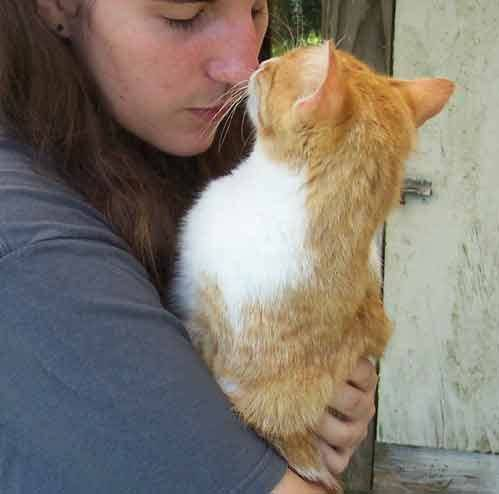

prediction: 1.0


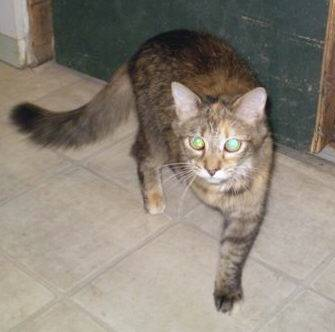

prediction: 1.0


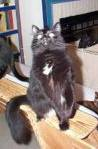

In [13]:
from IPython.display import Image, display
for cat in samplecat:
    print ("prediction:"), cat.prediction
    display(Image(cat.image.origin[5:]))

prediction: 2.0


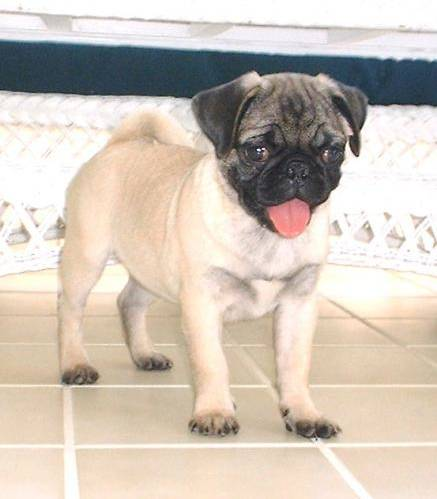

prediction: 2.0


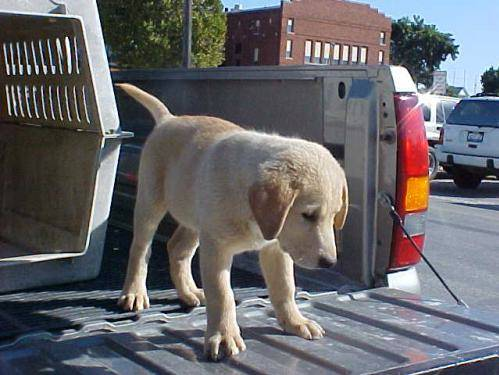

prediction: 2.0


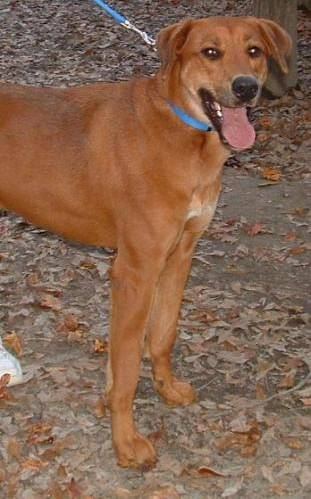

In [14]:
for dog in sampledog:
    print ("prediction:"), dog.prediction
    display(Image(dog.image.origin[5:]))